# Programming in Python
## Exam: January 21, 2025

You can solve the exercises below by using standard Python 3.12 libraries, NumPy, Matplotlib, Pandas, PyMC.
You can browse the documentation: [Python](https://docs.python.org/3.12/), [NumPy](https://numpy.org/doc/1.26/index.html), [Matplotlib](https://matplotlib.org/3.10.0/users/index.html), [Pandas](https://pandas.pydata.org/pandas-docs/version/2.2/index.html), [PyMC](https://www.pymc.io/projects/docs/en/stable/api.html).
You can also look at the [slides](https://homes.di.unimi.it/monga/lucidi2425/pyqb00.pdf) or your code on [GitHub](https://github.com).

**It is forbidden to communicate with others or "ask questions" online (i.e., stackoverflow is ok if the answer is already there, but you cannot ask a new question or use ChatGPT and similar products)**

To test examples in docstrings use

```python
import doctest
doctest.testmod()
```


In [5]:
import numpy as np
import pandas as pd             # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pymc as pm               # type: ignore
import arviz as az              # type: ignore

### Exercise 1 (max 2 points)

The file [bird_foo_data.csv](./bird_foo_data.csv) dataset contains the data from all fox diet studies that were analysed to generate the frequency of occurrence of birds in fox diets across Australia. The data come from: 
Stobo-Wilson, A., Murphy, B., Legge, S., Caceres-Escobar, H., Chapple, D., Crawford, H., Dawson, S., Dickman, C., Doherty, T., Fleming, P., Garnett, S., Gentle, M., Newsome, T., Palmer, R., Rees, M., Ritchie, E., Speed, J., Stuart, J.-M., Suarez-Castro, A., … Woinarski, J. (2022). Counting the bodies: estimating the numbers and spatial variation of Australian reptiles, birds and mammals killed by two invasive mesopredators [Zenodo](https://doi.org/10.5061/dryad.bk3j9kdcz)

Read the dataset in a DataFrame `birds`, use the ID column as the index.


Columns: subheadings:
- taxon: the taxon group that the dataset relates to
- type: specifies whether the diet data was collected from fox scat or fox stomach samples or both
- p_scat: the proportion of fox diet data that was collected from fox scats relative to fox stomachs
- samples: the number of individual fox diet samples that were collected
- total_in: the total number of individuals identified from fox stomach diet samples 
- mean_in: the mean number of individuals identified per fox stomach from all fox diet stomach 	samples
- map: mean annual precipitation at the study location where fox diet samples were collected 
- mat: mean annual temperature at the study location where fox diet samples were collected
- cover: mean tree cover at the study location where fox diet samples were collected
- rugged: topographic ruggedness at the study location where fox diet samples were collected
- popden: human population density at the study location where fox diet samples were collected 
- vast: vegetation disturbance at the study location where fox diet samples were collected
- distcoast: distance to coast at the study location where fox diet samples were collected 


In [6]:
birds=pd.read_csv('bird_foo_data.csv',index_col='ID')
print(birds.head())

   taxon     type  p_scat  samples  total_in  mean_in         map        mat  \
ID                                                                             
1   bird     scat     1.0       56       NaN      NaN  731.222222  16.883380   
2   bird     scat     1.0      163       NaN      NaN  838.900000  15.659748   
3   bird  stomach     0.0       26       NaN      NaN  710.333333  14.735649   
4   bird  stomach     0.0       29       NaN      NaN  394.083333  16.057292   
5   bird  stomach     0.0      148       NaN      NaN  908.000000  12.395999   

        cover      rugged  
ID                         
1   45.375757   92.275567  
2   51.326711  109.869334  
3   11.761714   55.019088  
4    0.852557  140.596608  
5    9.706605   46.606924  


### Exercise 2 (max 4 points)

Compute the number of samples collected in the scat and in the stomach. When the `type` column is "both (not stated)" or "scat & stomach" use the value of `p_scat` to distribuite the samples between the two types (float values are ok). To get the full marks do not use explicit loops.

In [7]:
cond_scat=birds['type']=='scat'
cond_stomach=birds['type']=='stomach'
cond_both=birds['type'].isin(['both(not stated)','scat&stomach'])
n_scat=np.select(
[cond_scat,cond_stomach,cond_both],[birds['samples'],0,birds['samples']*birds['p_scat']],default=0
)
n_stomach=np.select(
[cond_scat,cond_stomach,cond_both],[0,birds['samples'],birds['samples']*(1-birds['p_scat'])],default=0
)
birds['n_scat']=n_scat
birds['n_stomach']=n_stomach
birds[['type','samples','p_scat','n_scat','n_stomach']].head()

,type,samples,p_scat,n_scat,n_stomach
ID,,,,,
1,scat,56,1.0,56.0,0.0
2,scat,163,1.0,163.0,0.0
3,stomach,26,0.0,0.0,26.0
4,stomach,29,0.0,0.0,29.0
5,stomach,148,0.0,0.0,148.0


### Exercise 3 (max 7 points)

Define a function which takes a takes a `pd.Series` (of integers) and it compute a (shorter) one with the sums of subsequent triplets of values.
For example if the series contains the values 1,2,3,4,5 the result should be a series with 6,9,12.

To get the full marks, you should declare correctly the type hints (the signature of the function) and add a doctest string.

In [8]:
def sum_triplets(s: pd.Series) -> pd.Series:
    """
    Return the sum of every three consecutive integers in the input series.
    For example:
    >>> sum_triplets(pd.Series([1,2,3,4,5]))
    0     6
    1     9
    2    12
    dtype: int64
    """
    return s.rolling(window=3).sum().dropna().astype(int).reset_index(drop=True)

print(sum_triplets(pd.Series([1,2,3,4,5])))

0     6
1     9
2    12
dtype: int32


### Exercise 4 (max 2 points)

Apply the function define in Exercise 3 to column `samples`. To get the full marks do not use explicit loops.

In [9]:
import pandas as pd
df = pd.DataFrame({'samples': [1, 2, 3, 4, 5]})
df['triplets_sum']=sum_triplets(df['samples'])

### Exercise 5 (max 5 points)

Make a copy of the DataFrame `birds` in which every row with `type` "both (not stated)" or "scat & stomach" is duplicated: one row should have
type "scat" and the other "stomach", the `samples` and `total_in` (if is not n/a) are distributed according to `p_scat`. Use only integer numbers for the samples and be sure the sum of samples is preserved for each pair of duplicated rows.

In [10]:
import pandas as pd
import numpy as np

# 假定 birds 已经存在，结构需含 'type', 'samples', 'total_in', 'p_scat'

# 1. 标记需要拆分的行
split_mask = birds['type'].isin(['both (not stated)', 'scat & stomach'])

# 2. 处理拆分
def split_row(row):
    n = int(row['samples'])
    p = float(row['p_scat'])
    # 拆分样本量
    scat_samples = int(np.round(n * p))
    stomach_samples = n - scat_samples

    # 拆分 total_in（注意 total_in 可能为 NaN）
    if pd.notna(row['total_in']):
        total_in = int(row['total_in'])
        scat_total = int(np.round(total_in * p))
        stomach_total = total_in - scat_total
    else:
        scat_total = np.nan
        stomach_total = np.nan

    # 构造两行
    scat_row = row.copy()
    scat_row['type'] = 'scat'
    scat_row['samples'] = scat_samples
    scat_row['total_in'] = scat_total

    stomach_row = row.copy()
    stomach_row['type'] = 'stomach'
    stomach_row['samples'] = stomach_samples
    stomach_row['total_in'] = stomach_total

    return pd.DataFrame([scat_row, stomach_row])

# 只对需要拆分的行 apply，然后把所有行合并起来
split_part = birds[split_mask].apply(split_row, axis=1)
split_part = pd.concat(split_part.values, ignore_index=True)

# 其余不需拆分行，直接取来
keep_part = birds[~split_mask].copy()

# 拼接结果
birds_result = pd.concat([keep_part, split_part], ignore_index=True)

# （可选：排序或重置索引，视需求而定）

# 查看结果
print(birds_result)

    taxon     type  p_scat  samples  total_in  mean_in          map  \
0    bird     scat    1.00       56       NaN      NaN   731.222222   
1    bird     scat    1.00      163       NaN      NaN   838.900000   
2    bird  stomach    0.00       26       NaN      NaN   710.333333   
3    bird  stomach    0.00       29       NaN      NaN   394.083333   
4    bird  stomach    0.00      148       NaN      NaN   908.000000   
..    ...      ...     ...      ...       ...      ...          ...   
152  bird  stomach    0.95        8       NaN      NaN   335.555556   
153  bird     scat    0.97      133       NaN      NaN   564.333333   
154  bird  stomach    0.97        4       NaN      NaN   564.333333   
155  bird     scat    0.96       53       NaN      NaN  1164.750000   
156  bird  stomach    0.96        2       NaN      NaN  1164.750000   

           mat      cover      rugged  n_scat  n_stomach  
0    16.883380  45.375757   92.275567    56.0        0.0  
1    15.659748  51.326711  10

### Exercise 6 (max 4 points)

Add to the DataFrame birds a column with the standardized value of `total_in`. Remember that the standardized value measures how many standard deviations a specific value is far from the mean. If you have a ndarray of values `xx`: `(xx - xx.mean())/xx.std()`. Then plot a density histogram of this new column. 

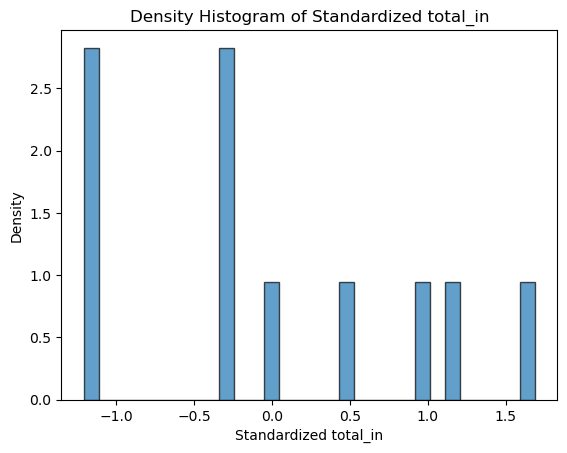

In [11]:
import matplotlib.pyplot as plt

# 1. 计算标准化列
mean = birds['total_in'].mean()
std = birds['total_in'].std()
birds['total_in_std'] = (birds['total_in'] - mean) / std

# 2. 画出密度直方图（去除缺失值）
birds['total_in_std'].plot(kind='hist', bins=30, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Standardized total_in')
plt.ylabel('Density')
plt.title('Density Histogram of Standardized total_in')
plt.show()

### Exercise 7 (max 4 points)


Plot a matrix of scatter plots (for each pair a,b you can plot just a,b and leave b,a empty) of all the combinations of `map`, `mat`, `cover`, `ragged`. They should appear all in the same figure. Put also a proper title to each plot.

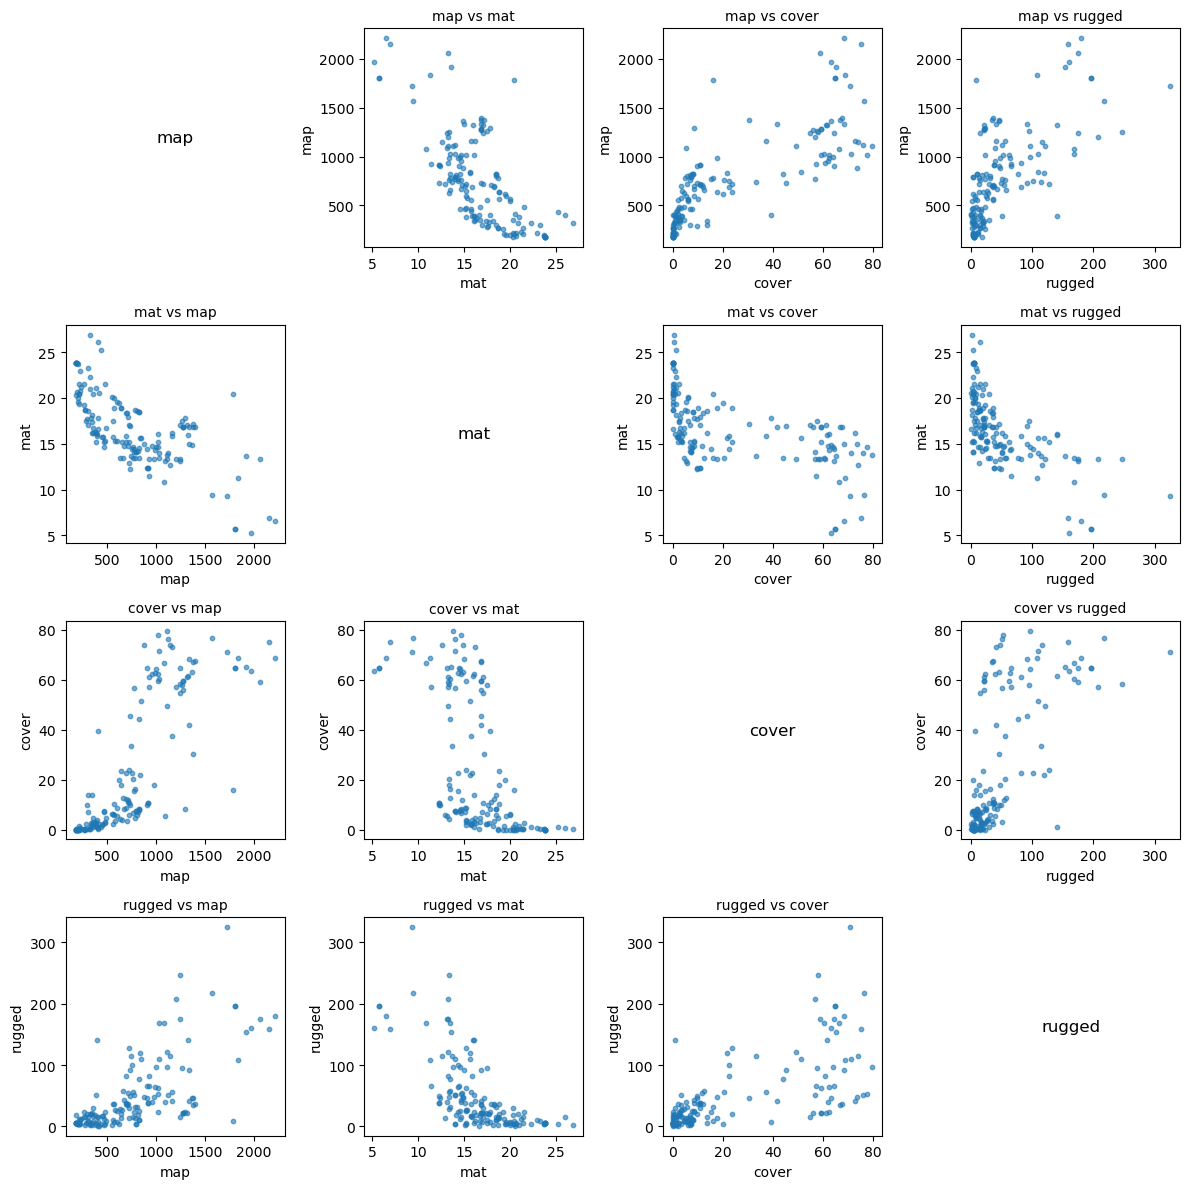

In [12]:

# columns to use for scatter plot matrix
cols = ['map', 'mat', 'cover', 'rugged']
n = len(cols)  # 总变量数

fig, axes = plt.subplots(n, n, figsize=(12, 12))  # 4x4大的画布

for i, col_x in enumerate(cols):        # 遍历行方向的变量
    for j, col_y in enumerate(cols):    # 遍历列方向的变量
        ax = axes[i, j]                 # 找到对应子图
        if i == j:
            ax.text(0.5, 0.5, f'{col_x}', ha='center', va='center', fontsize=12)
            ax.set_axis_off()  # 对角线上只写字不画坐标
        else:
            ax.scatter(birds[col_y], birds[col_x], s=10, alpha=0.6)
            # 绘制x=col_y, y=col_x的散点图
            ax.set_xlabel(col_y)
            ax.set_ylabel(col_x)
            ax.set_title(f'{col_x} vs {col_y}', fontsize=10)

plt.tight_layout()  # 合理排布不挤
plt.show()  # 展示画好的矩阵

### Exercise 8 (max 5 points)

Consider this statistical model: 

- the parameter $\alpha$ is normally distributed with mean 0, and stdev 3
- the parameter $\beta$ is normally distributed with mean 0, and stdev 5
- the parameter $\sigma$ is exponentially distributed with $\lambda = 1$
- the the mean of the observed value of `map` is given by $\alpha + \beta\cdot C$ where C is the observed value of `cover`, its std deviation is $\sigma$

Use PyMC to sample the posterior distributions after having seen the actual values for `map`.  Plot the posterior.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


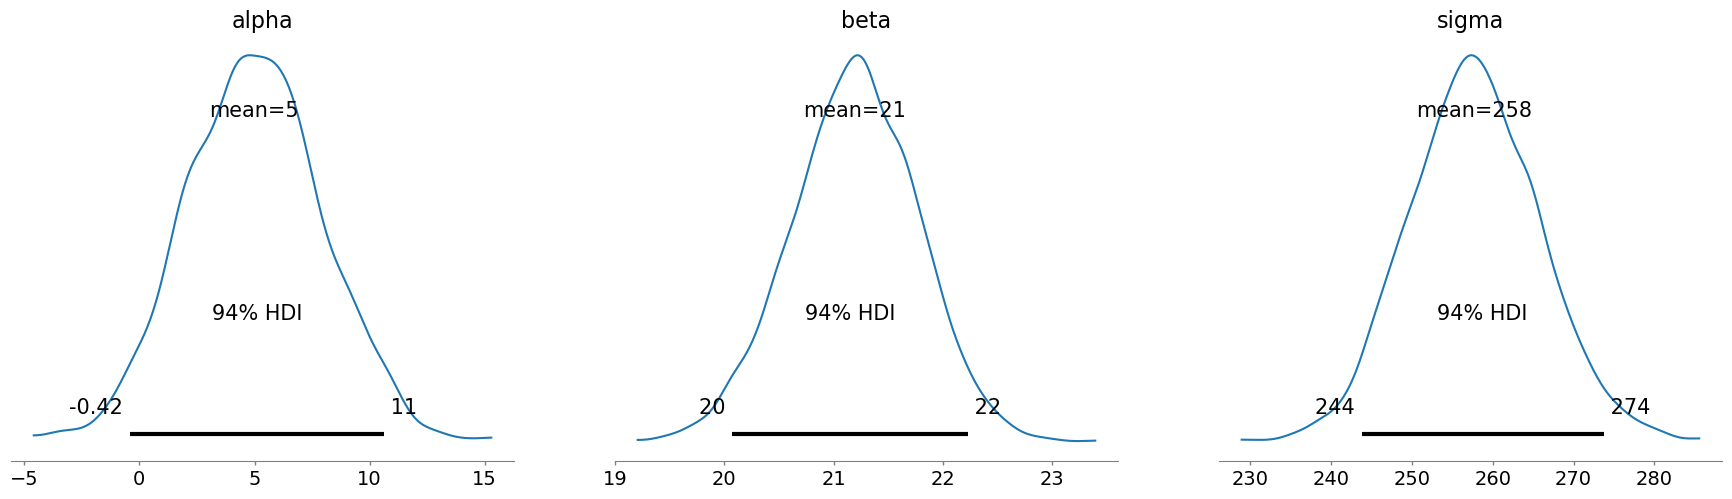

In [13]:
# 假设birds DataFrame已包含真实map和cover列
map_obs = birds['map'].values
cover_obs = birds['cover'].values

with pm.Model() as model:
    # 先验分布
    alpha = pm.Normal('alpha', mu=0, sigma=3)
    beta = pm.Normal('beta', mu=0, sigma=5)
    sigma = pm.Exponential('sigma', lam=1)

    # 线性关系
    mu = alpha + beta * cover_obs

    # 观测分布
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=map_obs)

    # 采样
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

# 画后验分布
az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])
plt.show()